In [1]:
import numpy as np 
import cv2
from PIL import Image 
import os 
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Concatenate, UpSampling2D, MaxPooling2D
from keras.models import Model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.transform import resize
from skimage.io import imsave
from skimage.color import rgb2lab, lab2rgb
from tqdm import tqdm
import re



2024-06-30 15:50:11.481227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 15:50:11.481399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 15:50:11.613132: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# dataset used in programm: /kaggle/input/landscape-image-colorization

def convert(text):
    if text.isdigit():
        return int(text)
    else:
        return text.lower()

def alphanum_key(key):
    parts = re.split('([0-9]+)', key)
    return [convert(part) for part in parts]

def final_sort(data):
    return sorted(data, key=alphanum_key)


color_img = []
path = '/kaggle/input/landscape-image-colorization/landscape Images/color'
files = os.listdir(path)
files = final_sort(files)

for i in tqdm(files):    
    if i == '5000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (240, 240))
        img = img.astype('float32') / 255.0
        img = img_to_array(img)
        color_img.append(img)


gray_img = []
path = '/kaggle/input/landscape-image-colorization/landscape Images/gray'
files = os.listdir(path)
files = final_sort(files)
for i in tqdm(files):
     if i == '5000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.resize(img, (240, 240))
        img = img.astype('float32') / 255.0
        img = img_to_array(img)
        gray_img.append(img)

 70%|███████   | 5000/7129 [00:34<00:14, 143.10it/s]


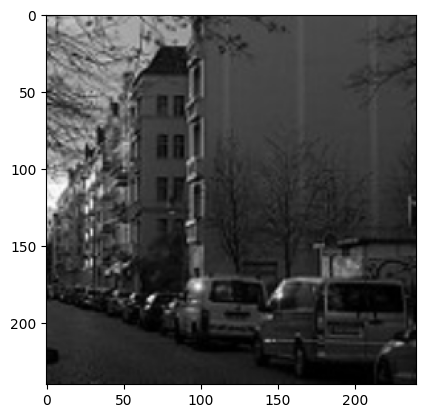

In [3]:
plt.imshow(gray_img[0])
plt.show()

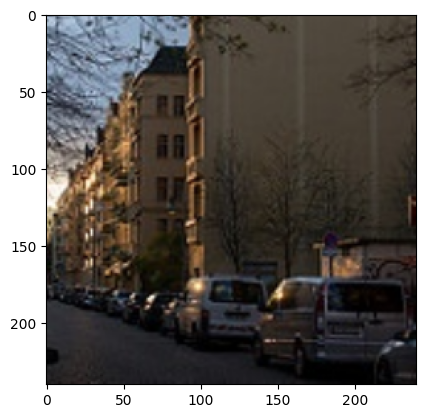

In [4]:
plt.imshow(color_img[0])
plt.show()

In [5]:
color_img = np.array(color_img)
color_img.shape

(5000, 240, 240, 3)

In [6]:
gray_img = np.array(gray_img)
gray_img.shape

(5000, 240, 240, 3)

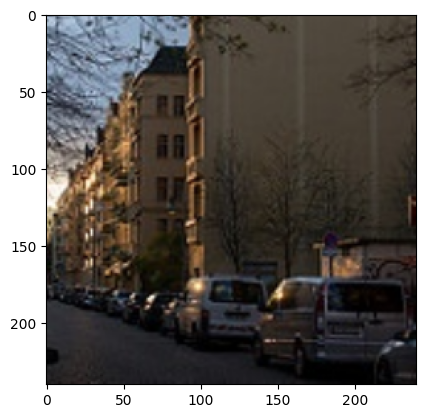

In [7]:
plt.imshow(color_img[0])
plt.show()     

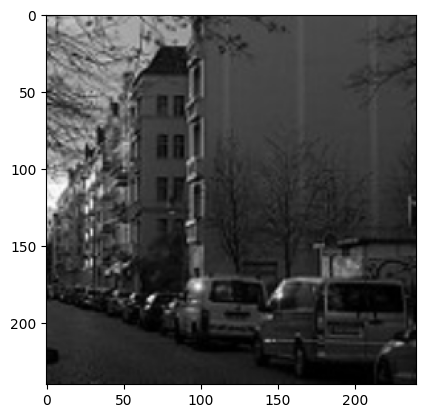

In [8]:
plt.imshow(gray_img[0])
plt.show()    

In [9]:
train_gray_image = gray_img[:4500]
train_color_image = color_img[:4500]

test_gray_image = gray_img[4500:]
test_color_image = color_img[4500:]

In [10]:
print(train_gray_image.shape)
print(train_color_image.shape)

print(test_gray_image.shape)
print(test_color_image.shape)


(4500, 240, 240, 3)
(4500, 240, 240, 3)
(500, 240, 240, 3)
(500, 240, 240, 3)


In [11]:
inputs = Input(shape=(240, 240, 3))

# Encoder

# 240x240x3
d1 = Conv2D(64, (3, 3), padding='same', strides=2)(inputs)
x = BatchNormalization()(d1)
x = LeakyReLU()(x)
# 120x120x64


# 120x120x64
d2 = Conv2D(128, (3, 3), padding='same', strides=2)(x)
x = BatchNormalization()(d2)
x = LeakyReLU()(x)
# 60x60x128


# 60x60x128
d3 = Conv2D(256, (3, 3), padding='same', strides=2)(x)
x = BatchNormalization()(d3)
x = LeakyReLU()(x)
# 30x30x256

# 30x30x256
d4 = Conv2D(512, (3, 3), padding='same', strides=2)(x)
x = BatchNormalization()(d4)
x = LeakyReLU()(x)
# 15x15x512

# 15x15x512
d5 = Conv2D(512, (3, 3), padding='same', strides=3)(x)
x = BatchNormalization()(d5)
encoded = LeakyReLU()(x)
# 5x5x512

# --------------------------------------------------------------
# Decoder
# 5x5x512
u4 = Conv2D(512, (3, 3), padding='same')(encoded)
x = Concatenate()([d5, u4])
x = BatchNormalization()(x)
x = LeakyReLU()(x)
# 5x5x1024


# 5x5x1024
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D((3, 3))(x)
# 15x15x512

# 15x15x512 -> 15x15x1024
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
u3 = LeakyReLU()(x)
x = Concatenate()([d4, u3])
# 15x15x1024

# 15x15x1024 -> 30x30x512
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
# 30x30x512

#  30x30x512 -> 30x30x256
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
u2 = LeakyReLU()(x)
# 30x30x256

# 30x30x256 -> 30x30x512
x = Concatenate()([d3, u2])
# 30x30x512

# 30x30x512 -> 60x60x256
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
# 60x60x256


# 60x60x256 -> 60x60x128
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
u1 = LeakyReLU()(x)

# 60x60x128 
x = Concatenate()([d2, u1])
# 60x60x256

# 60x60x256 -> 60x60x256
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
# 60x60x256

# 60x60x256 -> 120x120x64
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
# 120x120x64


# 120x120x64
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
u0  = LeakyReLU()(x)

# 120x120x64 -> 120x120x128
x = Concatenate()([d1, u0])
# 120x120x128


# 160x160x128 -> 320x320x128
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
# 240, 240, 64

# 240x240x64 -> # 240x240x32
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Создание модели
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer="adam", loss="mse", metrics=['accuracy'])


In [12]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 120, 120,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 120, 120,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 120, 120,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 60, 60,    │     73,856 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 60, 60,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 30, 30,    │    295,168 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 15, 15,    │  1,180,160 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 5, 5, 512) │  2,359,808 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 5, 5, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 5, 5, 512) │  2,359,808 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,242,435 (81.03 MB)

 Trainable params: 21,232,387 (81.00 MB)

 Non-trainable params: 10,048 (39.25 KB)

In [13]:
autoencoder.fit(gray_img, color_img, epochs=110)

Epoch 1/110


I0000 00:00:1719762807.764399      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 106s 360ms/step - accuracy: 0.4213 - loss: 0.0180
Epoch 2/110
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.4810 - loss: 0.0069
Epoch 3/110
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.4962 - loss: 0.0064
Epoch 4/110
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step - accuracy: 0.5151 - loss: 0.0063
Epoch 5/110
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.5140 - loss: 0.0058
Epoch 6/110
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.5013 - loss: 0.0061
Epoch 7/110
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/step - accuracy: 0.5239 - loss: 0.0059
Epoch 8/110
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/step - accuracy: 0.5287 - loss: 0.0059
Epoch 9/110
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/step - accuracy: 0.5301 - loss: 0.0056
Epoch 10/110
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/step - accuracy: 0.5362 - loss: 0.0056
Epoch 11/110
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/step - accuracy: 0.5502 - loss: 0.0056
Epoch 12/110
157/15

In [8]:
inputs = Input(shape=(320, 320, 3))

# inputs = Input(shape=(240, 240, 3))

# Encoder

# 320x320x3
d1 = Conv2D(64, (3, 3), padding='same', strides=2)(inputs)
x = BatchNormalization()(d1)
x = LeakyReLU()(x)
# 160x160x64


# 160x160x64
d2 = Conv2D(128, (3, 3), padding='same', strides=2)(x)
x = BatchNormalization()(d2)
x = LeakyReLU()(x)
# 80x80x128


# 80x80x128
d3 = Conv2D(256, (3, 3), padding='same', strides=2)(x)
x = BatchNormalization()(d3)
x = LeakyReLU()(x)
# 40x40x256

# 40x40x256
d4 = Conv2D(512, (3, 3), padding='same', strides=2)(x)
x = BatchNormalization()(d4)
x = LeakyReLU()(x)
# 20x20x512

# 20x20x512
d5 = Conv2D(512, (3, 3), padding='same', strides=2)(x)
x = BatchNormalization()(d5)
x = LeakyReLU()(x)
# 10x10x512

# 10x10x512 -> 5x5x512
d6 = Conv2D(512, (3, 3), padding='same', strides=2)(x)
x = BatchNormalization()(d6)
# 5x5x512
encoded = LeakyReLU()(x)


# --------------------------------------------------------------
# Decoder
# 5x5x512
u4 = Conv2D(512, (3, 3), padding='same')(encoded)
x = Concatenate()([d6, u4])
x = BatchNormalization()(x)
x = LeakyReLU()(x)
# 5x5x1024
x = UpSampling2D((2, 2))(x)
# 10x10x1024

# 10x10x1024
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
# 10x10x512

# 10x10x512 -> 10x10x1024
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
u3 = LeakyReLU()(x)
x = Concatenate()([d5, u3])
# 10x10x1024

# 10x10x1024 -> 20x20x512
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
# 20x20x512


# 20x20x512 -> 20x20x256
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
u2 = LeakyReLU()(x)
x = UpSampling2D((2, 2))(u2)

# 20x20x256 -> 20x20x512
x = Concatenate()([d4, u2])

# 20x20x512 -> 40x40x256
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
# 40x40x256


# 40x40x256 -> 40x40x128
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 40x40x128 -> 80x80x128
u1 = UpSampling2D((2, 2))(x)
# 80x80x128
x = Concatenate()([d3, u1])
# 80x80x256

# 80x80x256 -> 80x80x256
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
# 80x80x128

# 80x80x128 -> 80x80x64
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
# 80x80x64

#  80x80x64 -> 160x160x64
u0 = UpSampling2D((2, 2))(x)
# 160x160x64 -> 160x160x128
x = Concatenate()([d2, u0])
# 160x160x128


# 160x160x128 -> 320x320x128
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
# 320, 320, 64

# 320, 320, 256
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
# 320, 320, 32

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Создание модели
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer="adam", loss="mse", metrics=['accuracy'])


In [9]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 160, 160,  │      1,792 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 160, 160,  │        256 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_62      │ (None, 160, 160,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 80, 80,    │     73,856 │ leaky_re_lu_62[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        512 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_63      │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 40, 40,    │    295,168 │ leaky_re_lu_63[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │      1,024 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_64      │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 20, 20,    │  1,180,160 │ leaky_re_lu_64[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │      2,048 │ conv2d_65[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_65      │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 10, 10,    │  2,359,808 │ leaky_re_lu_65[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │      2,048 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_66      │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 5, 5, 512) │  2,359,808 │ leaky_re_lu_66[0

 Total params: 24,341,251 (92.85 MB)

 Trainable params: 24,330,307 (92.81 MB)

 Non-trainable params: 10,944 (42.75 KB)

In [21]:
autoencoder.fit(gray_img, color_img, epochs=125)

Epoch 1/125
  1/188 ━━━━━━━━━━━━━━━━━━━━ 2:04:45 40s/step - accuracy: 0.3886 - loss: 0.1004

I0000 00:00:1719739691.594904      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 83s 229ms/step - accuracy: 0.4228 - loss: 0.0183
Epoch 2/125
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.4723 - loss: 0.0092
Epoch 3/125
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.4871 - loss: 0.0084
Epoch 4/125
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.4970 - loss: 0.0081
Epoch 5/125
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.5057 - loss: 0.0080
Epoch 6/125
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.5084 - loss: 0.0076
Epoch 7/125
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.5283 - loss: 0.0072
Epoch 8/125
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.5299 - loss: 0.0072
Epoch 9/125
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.5312 - loss: 0.0069
Epoch 10/125
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.5357 - loss: 0.0069
Epoch 11/125
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.5438 - loss: 0.0064
Epoch 12/125
188/188

In [14]:
loss = autoencoder.evaluate(test_gray_image, test_color_image)
print(f"Loss: {loss}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 648ms/step - accuracy: 0.8079 - loss: 8.1655e-04
Loss: [0.0008671898976899683, 0.8117531538009644]


In [16]:
res = autoencoder.predict(test_gray_image)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step


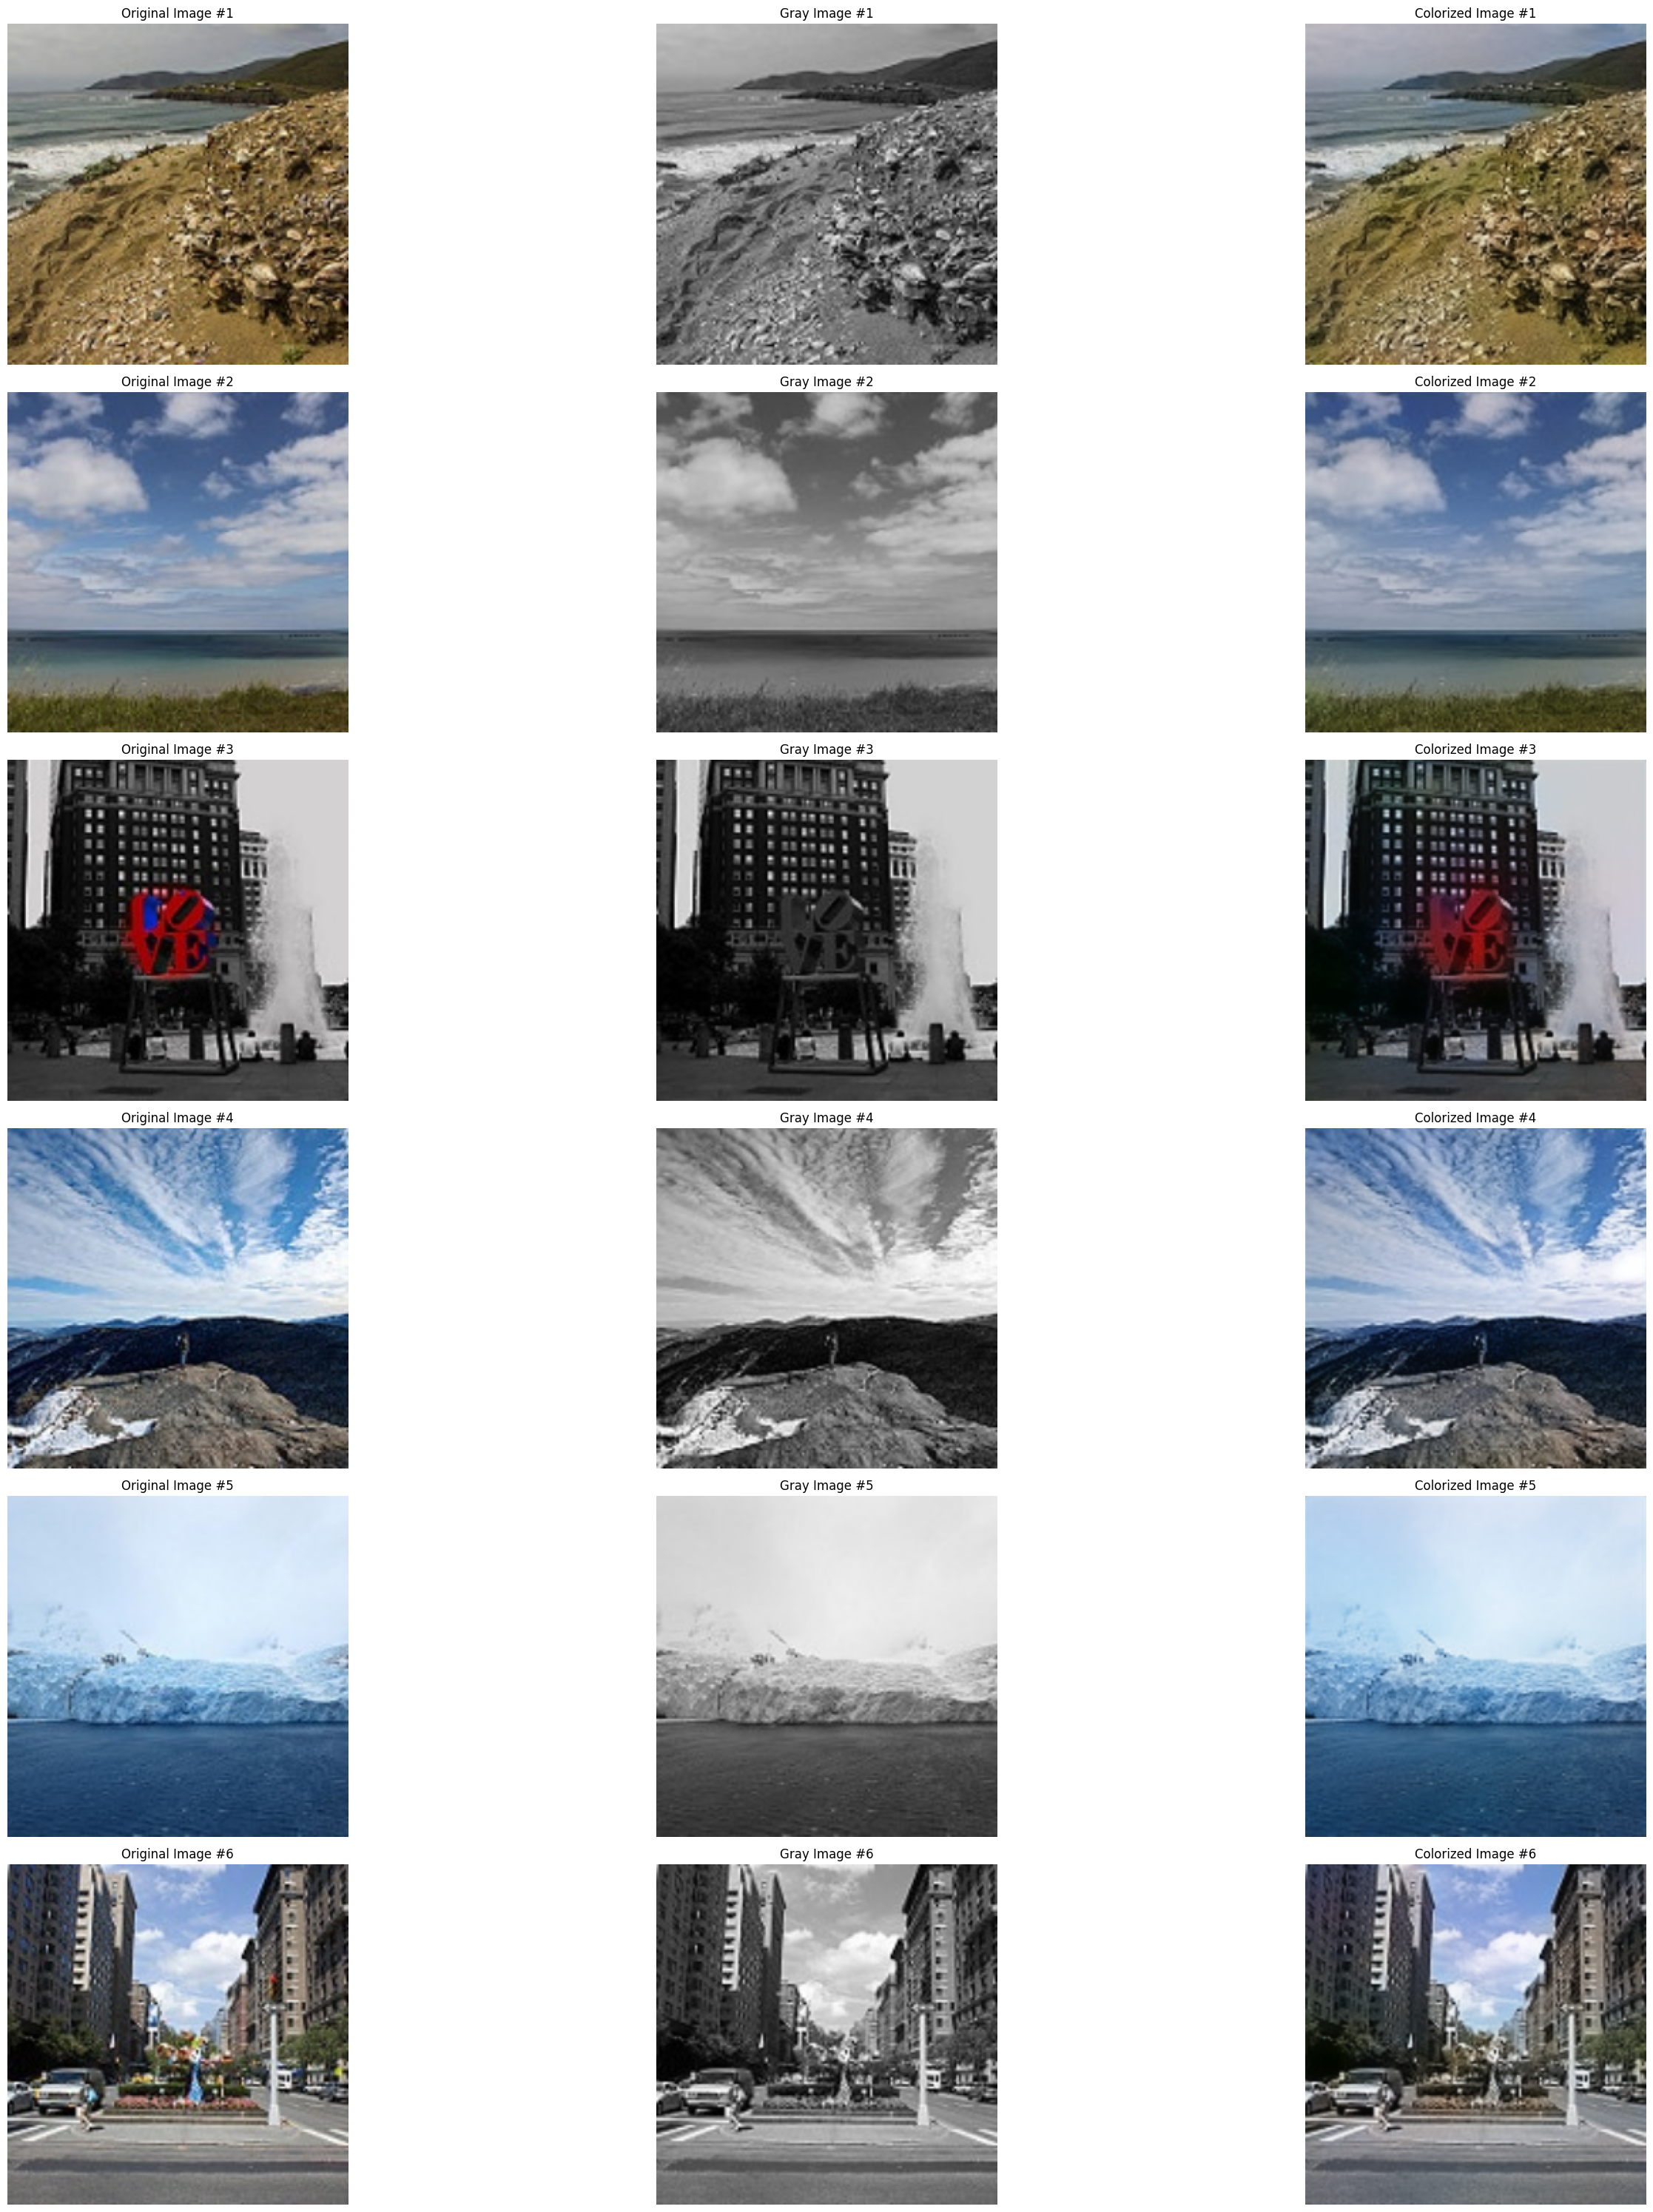

In [17]:
num_images = 6

fig, axes = plt.subplots(num_images, 3, figsize=(30, 30))

for i in range(num_images):
    
    axes[i, 0].imshow(test_color_image[i], cmap='gray')
    axes[i, 0].set_title(f'Original Image #{i+1}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(test_gray_image[i], cmap='gray')
    axes[i, 1].set_title(f'Gray Image #{i+1}')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(res[i])
    axes[i, 2].set_title(f'Colorized Image #{i+1}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [31]:
import pickle

with open("autoencoder.pickle", "wb") as file:
    pickle.dump(autoencoder, file)
    

In [18]:
autoencoder.save("autoencoder_new.h5")